In [1]:
from data_preprocessing.cleaning import clean_audio_folder
from data_preprocessing.augmentation.audio import augment_audio_files
from data_preprocessing.merging import merge_audios_by_speakers
from data_preprocessing.splitting import split_audio_files
from data_preprocessing.spectrogram_converter import convert_audio_files_to_images
from data_preprocessing.spectrogram_sharpener import sharpen_spectrograms

%load_ext autoreload
%autoreload 2

C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
import glob
from math import sqrt
import re
from typing import Dict, List

from matplotlib import pyplot as plt
from tqdm import tqdm


files = glob.glob("../data/tsrc/train/**/*.wav", recursive=True)
files_string = "\n".join(files)
word_speaker_to_files: Dict[str, List[str]] = {}



for file in tqdm(files):
    word = file.split("\\")[-2]
    speaker = file.split("\\")[-1].split(".")[-2].split("_")[0]

    word_speaker_key = f"{word}_{speaker}"

    if word_speaker_key in word_speaker_to_files:
        continue

    word_speaker_files = re.findall(rf'{word}\\{speaker}', files_string)
    word_speaker_to_files[word_speaker_key] = len(word_speaker_files)

file_occurances = [files_count for files_count in word_speaker_to_files.values()]

0it [00:00, ?it/s]


Text(0.5, 0, 'Count of different versions of same audio')

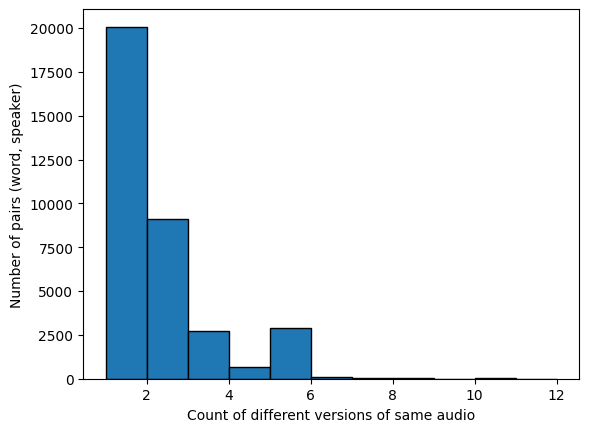

In [75]:
plt.hist(file_occurances, bins=11, edgecolor='black')
plt.ylabel('Number of pairs (word, speaker)')
plt.xlabel('Count of different versions of same audio')

In [73]:
import numpy as np


values, bins = np.histogram(file_occurances, bins=11)
print(values)
print(bins)

[20073  9080  2726   668  2902    80    31    24     8    15     2]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


(array([ 38.,   0.,  13.,   0.,  10.,   0.,  13.,   0.,   7.,   0.,  11.,
          0.,   8.,   0.,   7.,   0.,   6.,   0.,   7.,   0.,   8.,   0.,
          9.,   0.,   9.,   0.,  12.,   0.,  26.,   0.,   0.,  79.,   0.,
        162.,   0., 260.,   0., 385.,   0., 310.,   0., 223.,   0.,  88.,
          0.,  32.,   0.,   3.,   0.,   1.,   0.,   4.,   0.,   3.,   0.,
          1.,   0.,   9.,   0., 137.]),
 array([ 1.        ,  1.48333333,  1.96666667,  2.45      ,  2.93333333,
         3.41666667,  3.9       ,  4.38333333,  4.86666667,  5.35      ,
         5.83333333,  6.31666667,  6.8       ,  7.28333333,  7.76666667,
         8.25      ,  8.73333333,  9.21666667,  9.7       , 10.18333333,
        10.66666667, 11.15      , 11.63333333, 12.11666667, 12.6       ,
        13.08333333, 13.56666667, 14.05      , 14.53333333, 15.01666667,
        15.5       , 15.98333333, 16.46666667, 16.95      , 17.43333333,
        17.91666667, 18.4       , 18.88333333, 19.36666667, 19.85      ,
      

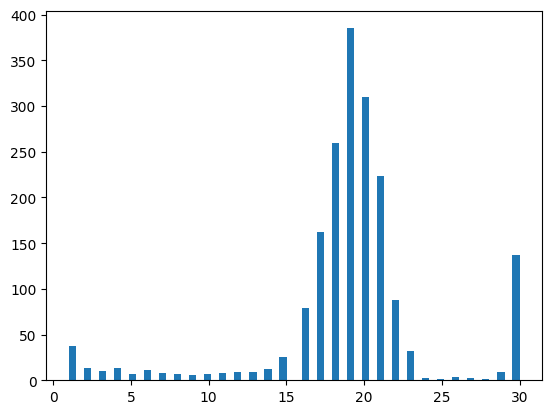

In [ ]:
import glob
from typing import Dict, List

from matplotlib import pyplot as plt


files = glob.glob("../data/tsrc/train/**/*_nohash_0.wav", recursive=True)
word_speaker_to_files: Dict[str, List[str]] = {}

for file in files:
    hash_id = file.split("\\")[-1].split("_")[-3]
    if hash_id not in word_speaker_to_files:
        word_speaker_to_files[hash_id] = []
    word_speaker_to_files[hash_id].append(file)


file_occurances = [len(files) for files in word_speaker_to_files.values()]
plt.hist(file_occurances, bins=60)

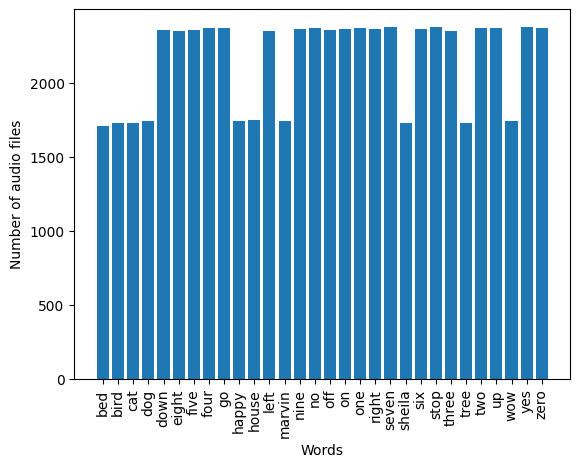

In [7]:
import glob
import os
from typing import Dict, List

from matplotlib import pyplot as plt

word_to_audio_files: Dict[str, List[str]] = {}

for word in os.listdir('../data/tsrc/train/audio'):
    if word == '_background_noise_':
        continue
    word_to_audio_files[word] = glob.glob(f"../data/tsrc/train/audio/{word}/*.wav")


file_occurances = [len(files) for files in word_to_audio_files.values()]
plt.bar(word_to_audio_files.keys(), file_occurances)
plt.xticks(rotation=90)
plt.ylabel('Number of audio files')
plt.xlabel('Words')
plt.show()

In [16]:
from functools import partial
from data_preprocessing.augmentation import compose
from data_preprocessing.augmentation import audio
from backend.spectrograms.utils import AudioLoader
import os

from data_preprocessing.augmentation import audio
transformations = compose.Compose([
    (partial(audio.change_pitch, n_steps = [-4, -3, -2, -1, 1, 2, 3, 4]), 0.2),
    (partial(audio.dist_augm), 0.2),
    (partial(audio.addReverb), 0.2),
    (partial(audio.getFirstSyllable), 0.1)
])


In [4]:
import random
import numpy as np
from data_preprocessing.train_test_split import train_test_split

random.seed(42)
np.random.seed(42)

In [7]:
train_test_split(
    '../data/tsrc/train/audio', 
    '../data/tsrc_train_test', 
)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [03:31<00:00,  6.83s/it]


zrobić balancowanie klas

In [2]:
clean_audio_folder('../data/tsrc_train_test', '../data/tsrc_cleaned')

Cleaning audio files for train data...


 23%|██████████████████                                                             | 279/1218 [00:07<00:27, 34.51it/s]C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\noisereduce\spectralgate\nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
100%|██████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:46<00:00, 35.12it/s]


Cleaning audio files for test data...


100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [00:15<00:00, 32.94it/s]


Cleaning audio files for validation data...


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:07<00:00, 33.50it/s]


In [17]:
audio.augment_audio_files('../data/tsrc_cleaned', '../data/cleaned_and_not_cleaned/tsrc_cleaned_augmented_syllable2', transformations, 7000, 2500)

Loading audio files... ../data/tsrc_cleaned\train


0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:08<00:00, 187.95it/s]


Loading audio files... ../data/tsrc_cleaned\validation


0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 161.51it/s]


Augmenting train
env:bed COUNT: 1222
wantedNoFilesPerClass : 7000, filesInEnv: 1222, augmentationRatio: 3.728314238952537
env:bird COUNT: 1218
wantedNoFilesPerClass : 7000, filesInEnv: 1218, augmentationRatio: 3.7471264367816093


C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


env:cat COUNT: 1209
wantedNoFilesPerClass : 7000, filesInEnv: 1209, augmentationRatio: 3.7899090157154673
env:dog COUNT: 1244
wantedNoFilesPerClass : 7000, filesInEnv: 1244, augmentationRatio: 3.627009646302251
env:down COUNT: 1662
wantedNoFilesPerClass : 7000, filesInEnv: 1662, augmentationRatio: 2.2117930204572804
env:eight COUNT: 1695
wantedNoFilesPerClass : 7000, filesInEnv: 1695, augmentationRatio: 2.129793510324484
env:five COUNT: 1627
wantedNoFilesPerClass : 7000, filesInEnv: 1627, augmentationRatio: 2.3023970497848802
env:four COUNT: 1655
wantedNoFilesPerClass : 7000, filesInEnv: 1655, augmentationRatio: 2.229607250755287
env:go COUNT: 1609
wantedNoFilesPerClass : 7000, filesInEnv: 1609, augmentationRatio: 2.35052827843381
env:happy COUNT: 1195
wantedNoFilesPerClass : 7000, filesInEnv: 1195, augmentationRatio: 3.8577405857740588
env:house COUNT: 1213
wantedNoFilesPerClass : 7000, filesInEnv: 1213, augmentationRatio: 3.770816158285243
env:left COUNT: 1660
wantedNoFilesPerClass :

94it [00:58,  1.60it/s]


In [18]:
convert_audio_files_to_images('../data/cleaned_and_not_cleaned/tsrc_cleaned_augmented_syllable2', '../data/cleaned_and_not_cleaned/tsrc_spectrograms_cleaned_augmented_syllable2')

Dataset: train. Converting bed files to images: 100%|██████████████████████████████| 4686/4686 [03:36<00:00, 21.66it/s]
Dataset: train. Converting bird files to images:   9%|██▊                           | 433/4704 [00:20<03:36, 19.75it/s]C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1556
  warnings.warn(
Dataset: train. Converting bird files to images:  21%|██████▏                      | 1008/4704 [00:48<02:41, 22.84it/s]C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=549
  warnings.warn(
Dataset: train. Converting cat files to images:   3%|▊                              | 126/4714 [00:06<03:41, 20.72it/s]C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1812
  wa

In [19]:
sharpen_spectrograms('../data/cleaned_and_not_cleaned/tsrc_spectrograms_cleaned_augmented_syllable2', '../data/cleaned_and_not_cleaned/tsrc_spectrograms_cleaned_augmented_syllable2_sharpened')

Dataset: train. Converting left files to images: 100%|█████████████████████████████| 4836/4836 [02:24<00:00, 33.52it/s]
Dataset: train. Converting marvin files to images: 100%|███████████████████████████| 4663/4663 [02:21<00:00, 32.98it/s]
Dataset: train. Converting seven files to images: 100%|████████████████████████████| 4865/4865 [02:27<00:00, 33.02it/s]
Dataset: train. Converting sheila files to images: 100%|███████████████████████████| 4663/4663 [02:25<00:00, 31.96it/s]
Dataset: test. Converting zero files to images: 100%|████████████████████████████████| 495/495 [00:14<00:00, 34.72it/s]
Dataset: validation. Converting bed files to images: 100%|█████████████████████████| 1080/1080 [00:31<00:00, 34.38it/s]
Dataset: validation. Converting bird files to images: 100%|████████████████████████| 1038/1038 [00:31<00:00, 32.56it/s]
Dataset: validation. Converting cat files to images: 100%|█████████████████████████| 1114/1114 [00:33<00:00, 32.82it/s]
Dataset: validation. Converting dog file

In [20]:
import glob
from typing import Dict
import numpy as np
import pandas as pd
import os

from model_training.cnn_classifier import CNNClassifier
from model_training.architectures.simple_convolution_network import SimpleConvolutionArchitecture

from model_training.measures import summary, get_true_and_predicted_labels

In [21]:
ARCHITRECTURE = SimpleConvolutionArchitecture()
FOLDER_PATH = "../models/simple_CNN_spectrograms_sharpened_cleaned_augmented_syllable2"
DATASET = '../data/cleaned_and_not_cleaned/tsrc_spectrograms_cleaned_augmented_syllable2_sharpened'
CLASS_LABELS = os.listdir(f"{DATASET}/train")

In [22]:
model = CNNClassifier(FOLDER_PATH, architecture=ARCHITRECTURE)
model.fit(
    f"{DATASET}/train", 
    f"{DATASET}/validation",
    batch_size=32,
    n_epochs=13,
)

C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Running training on GPU...


  8%|██████                                                                         | 1/13 [29:52<5:58:29, 1792.48s/it]

Epoch 0 Done after 1792.4833788871765 seconds


 15%|████████████▏                                                                  | 2/13 [51:10<4:33:09, 1489.92s/it]

Epoch 1 Done after 1278.1261694431305 seconds


 23%|█████████████████▊                                                           | 3/13 [1:12:17<3:51:19, 1387.95s/it]

Epoch 2 Done after 1266.6097044944763 seconds


 31%|███████████████████████▋                                                     | 4/13 [1:33:27<3:21:14, 1341.61s/it]

Epoch 3 Done after 1270.5532886981964 seconds


 38%|█████████████████████████████▌                                               | 5/13 [1:54:27<2:54:55, 1311.99s/it]

Epoch 4 Done after 1259.4434223175049 seconds


 46%|███████████████████████████████████▌                                         | 6/13 [2:15:14<2:30:29, 1289.90s/it]

Epoch 5 Done after 1247.0170962810516 seconds


 54%|█████████████████████████████████████████▍                                   | 7/13 [2:35:57<2:07:27, 1274.60s/it]

Epoch 6 Done after 1243.0961227416992 seconds


 62%|███████████████████████████████████████████████▍                             | 8/13 [2:56:50<1:45:38, 1267.76s/it]

Epoch 7 Done after 1253.1040332317352 seconds


 69%|█████████████████████████████████████████████████████▎                       | 9/13 [3:17:28<1:23:53, 1258.43s/it]

Epoch 8 Done after 1237.9169886112213 seconds


 77%|██████████████████████████████████████████████████████████▍                 | 10/13 [3:38:38<1:03:05, 1261.92s/it]

Epoch 9 Done after 1269.7068016529083 seconds


 85%|██████████████████████████████████████████████████████████████████            | 11/13 [3:59:29<41:57, 1258.60s/it]

Epoch 10 Done after 1251.0604724884033 seconds


 92%|████████████████████████████████████████████████████████████████████████      | 12/13 [4:20:38<21:01, 1261.95s/it]

Epoch 11 Done after 1269.5789458751678 seconds


100%|██████████████████████████████████████████████████████████████████████████████| 13/13 [4:41:39<00:00, 1299.93s/it]

Epoch 12 Done after 1260.2707092761993 seconds
Finished Training


In [23]:
y_true, y_pred = get_true_and_predicted_labels(model, f"{DATASET}/test")

In [7]:
df = pd.DataFrame({'y_true' : y_true, "y_pred" : y_pred })
df.to_csv(f"{FOLDER_PATH}/predictions.csv", index=False)

Accuracy: 0.843029976111582
Micro F1 Score: 0.843029976111582
Macro F1 Score: 0.8435669324529088
Weighted F1 Score: 0.8433371016507071


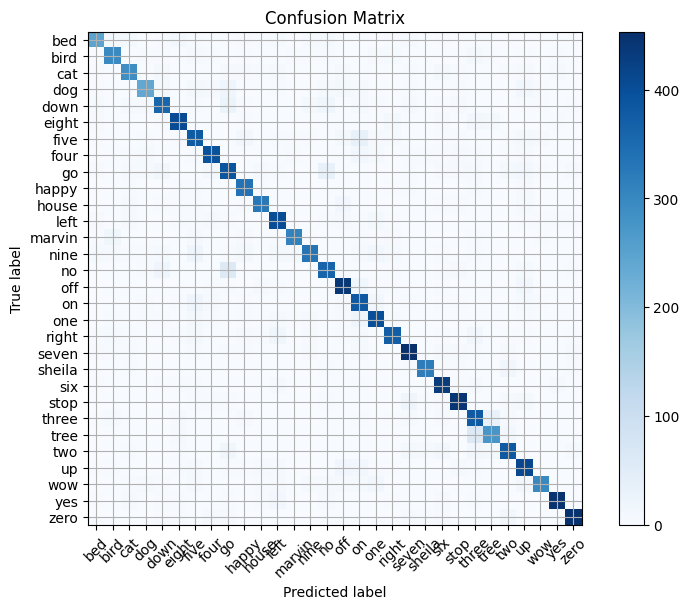

In [8]:
df = pd.read_csv(f"{FOLDER_PATH}/predictions.csv")
y_true = df["y_true"].values
y_pred = df["y_pred"].values
summary = summary(y_true, y_pred, CLASS_LABELS)